# Use AutoML for forecasting wind generation

Utilising MERRA2, ERA5 and ECWMF forecasts

https://www.ecmwf.int/en/forecasts/documentation-and-support/medium-range-forecasts

https://confluence.ecmwf.int/display/FCST/Implementation+of+AIFS+Single+v1

https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=overview
https://cds.climate.copernicus.eu/datasets/seasonal-monthly-single-levels?tab=overview



In [1]:
import requests
from pathlib import Path
from tqdm import tqdm

import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import zipfile

from autogluon.tabular import TabularPredictor

import os

import pickle

import cdsapi

import xarray as xr
import matplotlib.pyplot as plt

from autogluon.tabular import TabularPredictor

d:\GitHub\wind-automl\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
autoML_duration_mins = 4

In [3]:
lat = 52.4
lon = -0.94

In [4]:
BYTES_MB = 1024 * 1024

In [5]:
def download_file(url: str, outfile: str | Path) -> None:
    """
    Download a file from the web, based on its url, and save to the outfile.

    Args:
        url(:obj:`str`): Url of data to download.
        outfile(:obj:`str` | :obj:`Path`): File path to which the download is saved.
    """

    outfile = Path(outfile).resolve()
    result = requests.get(url, stream=True)

    with outfile.open("wb") as f:
        for chunk in tqdm(result.iter_content(chunk_size=BYTES_MB), desc="MB downloaded"):
            if chunk:
                f.write(chunk)


In [6]:
url = r"https://zenodo.org/records/8252025/files/Kelmarsh_12.3MW_6xSenvion_MM92.kmz?download=1"
outfile = Path("Kelmarsh_12.3MW_6xSenvion_MM92.kmz")

if not outfile.is_file():
    download_file(url,outfile)


In [7]:
data_path = "data/scada_energy_theoretical.csv"

if os.path.exists(data_path):
    # Load your existing predictor from its saved directory
    scada = pd.read_csv(data_path, index_col=0, parse_dates=True)
    
else:
    
    record_id = 8252025
    url_zenodo = r"https://zenodo.org/api/records/"
    r = requests.get(f"{url_zenodo}{record_id}")
    r_json = r.json()

    files = r_json["files"]

    for file in files:
        
        if "SCADA" in file["links"]["self"]:
    
            url = f"https://zenodo.org/records/8252025/files/{file["key"]}?download=1"
            outfile = Path(f"data/{file["key"]}")

            if not outfile.is_file():
                print(url)
                try:
                    download_file(url,outfile)
                except:
                    print("Failed to download file. Removing it.")
                    outfile.unlink()
                    continue

            with zipfile.ZipFile(outfile,"r") as zip_ref:
                zip_ref.extractall(path="data")

    scada_files = list(Path().rglob("data/Turbine_Data*.csv"))

    use_columns = [
                "# Date and time",
                #"Power (kW)",
                "Energy Theoretical (kWh)"
            ]

    csv_params = {
            "index_col": "# Date and time",
            "parse_dates": True,
            "skiprows": 9,
            "usecols": use_columns,
        }

    print(str(scada_files[0])[-42:-32])

    scada_lst = []

    for file in scada_files:
        turbine_name = str(file)[-42:-32] # TODO - should take name of file not the full path

        scada_wt = pd.read_csv(file, **csv_params)

        scada_wt["Turbine"] = turbine_name
        scada_wt.index.names = ["Timestamp"]
        scada_lst.append(scada_wt.copy())

    scada = pd.concat(scada_lst)

    scada.to_csv(data_path)

In [8]:
scada

,Energy Theoretical (kWh),Turbine
Timestamp,,
2016-01-03 00:00:00,NaN,Kelmarsh_1
2016-01-03 00:10:00,NaN,Kelmarsh_1
2016-01-03 00:20:00,NaN,Kelmarsh_1
2016-01-03 00:30:00,NaN,Kelmarsh_1
2016-01-03 00:40:00,NaN,Kelmarsh_1
...,...,...
2022-12-31 23:10:00,220.959389,Kelmarsh_6
2022-12-31 23:20:00,248.510113,Kelmarsh_6
2022-12-31 23:30:00,273.517162,Kelmarsh_6


In [9]:
for year in range(2000,2026):
    outfile = Path(f"data/era5/era5_{year}.grib")

    if not outfile.is_file():
        print(f"Downloading to: {outfile}")

        dataset = "reanalysis-era5-single-levels"
        request = {
            "product_type": ["reanalysis"],
            "variable": [
                "2m_temperature",
                "100m_u_component_of_wind",
                "100m_v_component_of_wind"
            ],
            "year": [str(year)],
            "month": ["01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12",],
            "day": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12",
                "13", "14", "15",
                "16", "17", "18",
                "19", "20", "21",
                "22", "23", "24",
                "25", "26", "27",
                "28", "29", "30",
                "31"
            ],
            "time": [
                "00:00", "01:00", "02:00",
                "03:00", "04:00", "05:00",
                "06:00", "07:00", "08:00",
                "09:00", "10:00", "11:00",
                "12:00", "13:00", "14:00",
                "15:00", "16:00", "17:00",
                "18:00", "19:00", "20:00",
                "21:00", "22:00", "23:00"
            ],
            "data_format": "grib",
            "download_format": "unarchived",
            "area": [lat+1, lon-1, lat-1, lon+1]
        }

        client = cdsapi.Client()
        client.retrieve(dataset, request, outfile)

In [10]:
outfile = Path(f"data/era5.csv")

if not outfile.is_file():
    print(f"Downloading to: {outfile}")
    
    # Open the dataset
    ds = xr.open_mfdataset(f"data/era5/era5_20*.grib", engine="cfgrib")

    # Reset unwanted coordinates
    ds = ds.reset_coords(['number', 'step', 'surface', 'valid_time'], drop=True)

    # Select the nearest grid point
    selected_data = ds.sel(latitude=lat, longitude=lon)

    # Convert the selected data to a pandas DataFrame
    df_era5 = selected_data.to_dataframe()

    # Save the DataFrame to a CSV file
    df_era5.to_csv(outfile)

else:
    df_era5 = pd.read_csv(outfile, index_col=0, parse_dates=True)


df_era5 = df_era5[["t2m","u100","v100"]]


for shift in range(-24,25,1):
    df_era5[f"u100_shift_{shift}"] = df_era5["u100"].shift(shift)
    df_era5[f"v100_shift_{shift}"] = df_era5["v100"].shift(shift)


d:\GitHub\wind-automl\.venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
d:\GitHub\wind-automl\.venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
d:\GitHub\wind-automl\.venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_

In [11]:
scada_hourly = scada.pivot(columns="Turbine", values="Energy Theoretical (kWh)")

scada_hourly = scada_hourly.dropna()

scada_hourly = scada_hourly.resample("h").sum()

In [12]:
scada_site_hourly = pd.DataFrame(scada_hourly.sum(axis=1))
scada_site_hourly.columns=["Energy Theoretical (kWh)"]

<Axes: xlabel='Timestamp'>

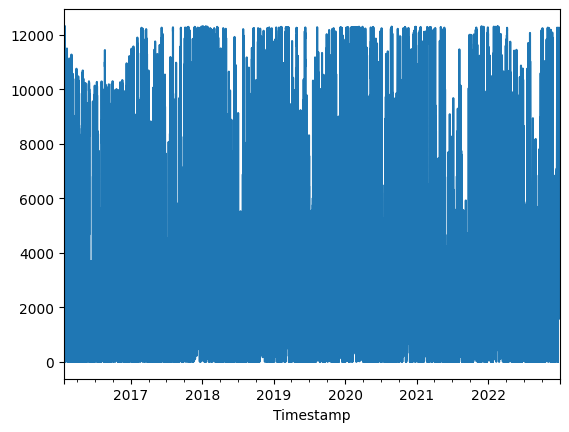

In [13]:
scada_site_hourly["Energy Theoretical (kWh)"].plot()

In [14]:
scada_site_hourly = scada_site_hourly.loc["2018":]

In [15]:
scada_site_hourly = scada_site_hourly.merge(df_era5, left_index=True, right_index=True)

In [16]:
scada_site_hourly

,Energy Theoretical (kWh),t2m,u100,v100,u100_shift_-24,v100_shift_-24,u100_shift_-23,v100_shift_-23,u100_shift_-22,v100_shift_-22,...,u100_shift_20,v100_shift_20,u100_shift_21,v100_shift_21,u100_shift_22,v100_shift_22,u100_shift_23,v100_shift_23,u100_shift_24,v100_shift_24
2018-01-01 00:00:00,11345.543629,278.652344,12.560888,1.699363,12.266776,-2.156241,11.930605,-2.185804,11.529160,-4.025177,...,10.669250,11.060684,10.395433,10.741347,8.055436,11.574661,3.932293,10.857471,-0.253211,9.511244
2018-01-01 01:00:00,10473.868241,277.734070,11.194722,3.775121,11.051239,-2.148818,12.266776,-2.156241,11.930605,-2.185804,...,10.533555,10.676737,10.669250,11.060684,10.395433,10.741347,8.055436,11.574661,3.932293,10.857471
2018-01-01 02:00:00,11540.792105,277.492737,10.416144,5.544930,10.379813,-1.214142,11.051239,-2.148818,12.266776,-2.156241,...,10.532361,10.118890,10.533555,10.676737,10.669250,11.060684,10.395433,10.741347,8.055436,11.574661
2018-01-01 03:00:00,11925.247621,277.425842,10.349656,6.660585,9.950237,-0.426959,10.379813,-1.214142,11.051239,-2.148818,...,10.962587,8.718340,10.532361,10.118890,10.533555,10.676737,10.669250,11.060684,10.395433,10.741347
2018-01-01 04:00:00,9878.207874,277.822083,10.623235,7.275044,9.447613,0.321022,9.950237,-0.426959,10.379813,-1.214142,...,10.568226,7.472130,10.962587,8.718340,10.532361,10.118890,10.533555,10.676737,10.669250,11.060684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,8205.421020,284.621399,7.288241,9.942937,3.678391,7.236674,4.014283,8.160983,3.600561,8.462399,...,7.221338,8.535692,7.924212,8.145590,8.902271,7.766553,9.033313,7.700175,9.769144,7.486769
2022-12-31 20:00:00,7940.013311,284.399353,8.392684,9.126948,3.364594,7.016080,3.678391,7.236674,4.014283,8.160983,...,6.496593,8.187078,7.221338,8.535692,7.924212,8.145590,8.902271,7.766553,9.033313,7.700175
2022-12-31 21:00:00,9899.108861,283.994629,8.520400,9.519152,3.058705,6.632362,3.364594,7.016080,3.678391,7.236674,...,5.621401,9.003526,6.496593,8.187078,7.221338,8.535692,7.924212,8.145590,8.902271,7.766553
2022-12-31 22:00:00,9722.141787,283.493347,7.296102,7.229867,2.942449,6.365264,3.058705,6.632362,3.364594,7.016080,...,5.365583,9.780439,5.621401,9.003526,6.496593,8.187078,7.221338,8.535692,7.924212,8.145590


In [17]:
target_feature = "Energy Theoretical (kWh)"

model_path = f"AutogluonModels/energy_forecasts/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}_{autoML_duration_mins:02d}mins"

if os.path.exists(model_path):
    # Load your existing predictor from its saved directory
    predictor = TabularPredictor.load(model_path)

else:
    # Training with AutoGluon
    predictor = TabularPredictor(
        label=target_feature, 
        eval_metric='mae',
        path=model_path,
    )
    predictor.fit(
        train_data=scada_site_hourly, 
        time_limit=60*autoML_duration_mins, 
        presets='best_quality', 
        num_gpus='auto', 
        num_cpus='auto',
    )

In [18]:
prediction_path = f"predictions/energy_forecasts/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}_{autoML_duration_mins:02d}mins.pkl"

if os.path.exists(prediction_path):
    # Load your existing predictor from its saved directory
    # Open the file for reading in binary mode
    with open(prediction_path, "rb") as file:
        # Load (deserialize) the object from the file
        target_prediction = pickle.load(file)

else:
    target_prediction = predictor.predict(df_era5)

    # Open a file for writing in binary mode
    with open(prediction_path, "wb") as file:
        # Serialize and save the object to the file
        pickle.dump(target_prediction, file)



In [19]:
target_prediction.name = "target_prediction"

In [20]:
target_prediction = pd.DataFrame(target_prediction)

In [21]:
target_prediction

,target_prediction
time,
2000-01-01 00:00:00,1441.577515
2000-01-01 01:00:00,1104.492798
2000-01-01 02:00:00,1114.134521
2000-01-01 03:00:00,1418.169312
2000-01-01 04:00:00,1632.723877
...,...
2025-02-23 15:00:00,10766.537109
2025-02-23 16:00:00,10643.005859
2025-02-23 17:00:00,10703.344727


In [22]:
target_result = scada_site_hourly.merge(target_prediction, left_index=True, right_index=True)

np.mean(abs(target_result["target_prediction"]-target_result[target_feature]))

114.23750119131834

In [23]:
# Assuming y_true and y_pred are NumPy arrays
ss_res = np.sum((target_result[target_feature] - target_result["target_prediction"]) ** 2)
ss_tot = np.sum((target_result[target_feature] - np.mean(target_result["target_prediction"])) ** 2)
r2_manual = 1 - (ss_res / ss_tot)
print("R2:", r2_manual)

R2: 0.997171885324084


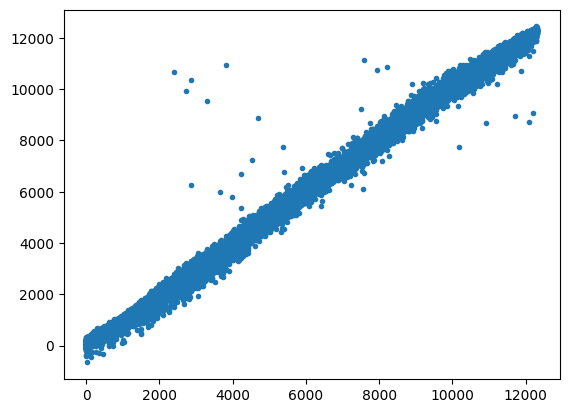

In [24]:
plt.figure()

plt.plot(target_result[target_feature],target_result["target_prediction"],marker='.',linestyle='')

plt.show()

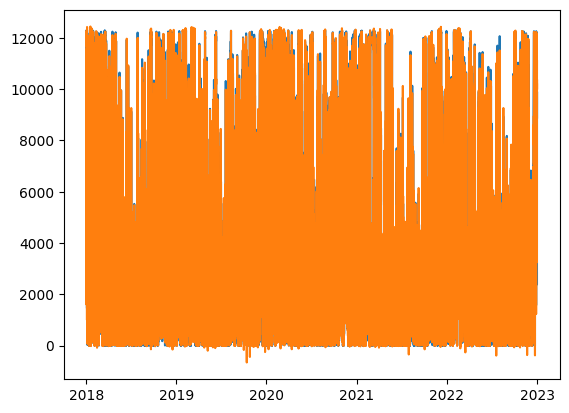

In [25]:
plt.figure()

plt.plot(target_result[target_feature])
plt.plot(target_result["target_prediction"])

plt.show()

C:\Users\Charlie\AppData\Local\Temp\ipykernel_4356\3663099147.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  target_prediction.resample("M").sum().plot()


<Axes: xlabel='time'>

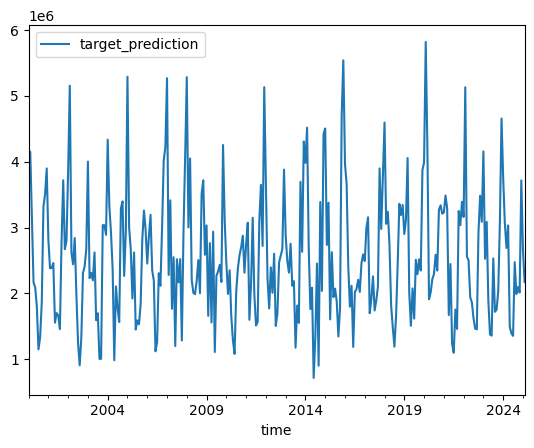

In [26]:
target_prediction.resample("M").sum().plot()

In [27]:
annual_prediction = target_prediction.resample("Y").sum()
annual_prediction

C:\Users\Charlie\AppData\Local\Temp\ipykernel_4356\3984842984.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_prediction = target_prediction.resample("Y").sum()


,target_prediction
time,
2000-12-31,32230300.0
2001-12-31,28402326.0
2002-12-31,29787680.0
2003-12-31,27630984.0
2004-12-31,31283150.0
2005-12-31,30966744.0
2006-12-31,31090120.0
2007-12-31,31975456.0
2008-12-31,35046516.0


In [28]:
prediction_monthly = target_prediction.resample("M").sum()
prediction_monthly["month"] = prediction_monthly.index.month
print(prediction_monthly.groupby("month").mean().sum())
prediction_monthly.groupby("month").mean()

target_prediction    30693326.0
dtype: float32


C:\Users\Charlie\AppData\Local\Temp\ipykernel_4356\3700431752.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  prediction_monthly = target_prediction.resample("M").sum()


,target_prediction
month,
1,3664580.500
2,3158495.500
3,2893126.000
4,2120534.500
5,2092286.500
6,1665585.250
7,1698253.875
8,1881659.000
9,2048533.625


In [40]:
prediction_8760 = target_prediction.copy()
prediction_8760["hour"] = (prediction_8760.index.day_of_year-1) * 24 + prediction_8760.index.hour
prediction_8760 = prediction_8760.groupby("hour").mean()
prediction_8760

,target_prediction
hour,
0,5628.403809
1,5511.345703
2,5497.230957
3,5560.569336
4,5622.108887
...,...
8779,5442.551758
8780,5475.717773
8781,5127.487305


In [ ]:
# prediction_8760 = target_prediction.copy()
# prediction_8760["day"] = prediction_8760.index.day_of_year
# prediction_8760["hour"] = prediction_8760.index.hour
# prediction_8760 = prediction_8760.groupby(["day","hour"]).mean()
# prediction_8760

target_prediction
day hour                   
1   0           5628.403809
    1           5511.345703
    2           5497.230957
    3           5560.569336
    4           5622.108887
...                     ...
366 19          5442.551758
    20          5475.717773
    21          5127.487305
    22          4952.871582
    23          4760.911621

[8784 rows x 1 columns]

In [31]:
prediction_8760.index = pd.to_datetime(prediction_8760.index, unit='h', origin=pd.Timestamp('2021-01-01'))

In [32]:
prediction_8760

,target_prediction
hour,
2021-01-01 00:00:00,5628.403809
2021-01-01 01:00:00,5511.345703
2021-01-01 02:00:00,5497.230957
2021-01-01 03:00:00,5560.569336
2021-01-01 04:00:00,5622.108887
...,...
2022-01-01 19:00:00,5442.551758
2022-01-01 20:00:00,5475.717773
2022-01-01 21:00:00,5127.487305


In [33]:
days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

In [34]:
prediction_12x24 = target_prediction.copy()
prediction_12x24["month"] = prediction_12x24.index.month
prediction_12x24["hour"] = prediction_12x24.index.hour
print((prediction_12x24.groupby(["month","hour"]).mean().unstack().sum(axis=1)*days_in_month).sum())
prediction_12x24.groupby(["month","hour"]).mean().unstack(["month"])

30685397.10546875


target_prediction                                                      \
month                1            2            3            4            5    
hour                                                                          
0           4945.625977  4705.641113  3860.380615  2972.266602  2758.876221   
1           4938.878906  4695.490723  3856.663574  2920.866455  2683.464600   
2           4935.298828  4634.229004  3865.256836  2871.168701  2628.144775   
3           4942.345703  4636.310059  3864.256348  2866.343262  2613.519531   
4           4921.815918  4614.561523  3869.737793  2845.269775  2631.333740   
5           4916.723633  4586.652344  3854.438965  2816.287109  2632.133545   
6           4918.722168  4593.401855  3812.210693  2803.179932  2639.419434   
7           4939.171387  4612.585449  3775.433594  2816.675049  2694.604004   
8           4914.383301  4648.304199  3736.220215  2850.662598  2738.756104   
9           4873.009277  4655.011230  3766.270996  2873.552246  2789.313477   
10          4809.092285  4715.727539  3848.049072  2926.376953  2846.590576   
11          4811.675293  4797.421875  3897.813477  2979.318604  2933.571533   
12          4882.650879  4850.183105  3981.789795  3031.086914  3020.582520   
13          4894.749512  4851.442871  4041.302002  3081.320557  3102.558350   
14          4855.777832  4777.697754  4075.669434  3126.831055  3101.263916   
15          4842.422363  4680.914551  4036.288330  3113.996338  3113.128662   
16          4887.459473  4596.774414  3967.360596  3091.041748  3070.237305   
17          4949.286133  4619.142578  3931.853760  3035.028564  2979.489014   
18          5031.073730  4650.397949  3895.370117  2988.269043  2850.441650   
19          5038.787598  4684.537109  3916.237793  2952.843018  2739.381836   
20          5055.180176  4708.728027  3906.127441  2951.850586  2699.160400   
21          5001.868652  4756.231934  3840.630371  2941.059082  2724.950439   
22          4959.574219  4737.256836  3861.347656  2906.681885  2753.270264   
23          4946.702148  4711.624023  3865.937988  2922.504639  2748.921875   

                                                                        \
month           6            7            8            9            10   
hour                                                                     
0      2287.190918  2252.613281  2439.741943  2746.485596  3884.923828   
1      2254.062744  2216.070312  2461.096680  2729.775391  3859.072998   
2      2234.077393  2171.032959  2422.520752  2718.922852  3833.537354   
3      2221.343018  2161.120850  2401.685791  2707.664795  3799.061523   
4      2171.970215  2168.180420  2372.419434  2711.947998  3775.209961   
5      2100.478760  2097.487061  2324.314209  2707.637695  3786.610352   
6      2081.712646  2038.002686  2261.282471  2700.586182  3806.323486   
7      2126.383545  2070.865479  2273.808594  2646.089844  3789.389404   
8      2164.139893  2108.566650  2344.681396  2655.100098  3773.740723   
9      2218.197510  2165.594238  2443.887207  2728.900391  3768.116211   
10     2272.017578  2227.020264  2566.334717  2801.049316  3893.985596   
11     2386.947266  2333.370117  2683.611328  2941.248779  4011.676025   
12     2486.746826  2426.336914  2817.086670  3070.152100  4074.455566   
13     2543.843750  2543.714844  2897.559326  3147.674316  4077.024902   
14     2560.382568  2620.327637  2892.848633  3140.519287  4001.292969   
15     2584.983154  2614.464355  2867.123291  3086.167725  3863.495605   
16     2541.282715  2566.828613  2819.887695  3022.070557  3751.003174   
17     2481.566406  2455.035400  2680.855957  2902.070557  3719.538818   
18     2380.620117  2346.552490  2505.252441  2854.878906  3804.113770   
19     2291.630615  2252.608887  2407.351074  2857.148682  3852.153809   
20     2251.881592  2205.697021  2423.242188  2869.734375  3852.207764   
21     2281.242188  2204.217285  2459.747559  2853.052979  3857.821533   
22     2282.397461  22